# Parking Availability

## Data
Data set contains:
 - timestamps when a parking session was started and finished: `START_TIME` and `END_TIME`
 - GPS coordinates of the location where a vehicle was parked: `Lon` and `Lat`

In [97]:
from bokeh.io import output_notebook, show
from bokeh.models import (GMapOptions, ColumnDataSource)
from bokeh.plotting import gmap

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import itertools

In [98]:
area_title = 'IJburg'
file_name_prefix = area_title.lower() + '_'
area_lat = 52.355
area_lon = 5
area_zoom = 14

restrict_initial_data_to = -1 #100000

v_area_split_by = 5 #11
h_area_split_by = 5 #11

downsampling_interval_in_minutes = 60

enforcement_start = 6
enforcement_end = 22
no_enforcement_weekdays = [6]

limit_by_spots = 5

GOOGLE_API_KEY = ''
with open('google_api.key', 'r') as myfile:
    GOOGLE_API_KEY = myfile.read()

In [99]:
class DataSetCleaner(object):
    def __init__(self, start_time, end_time, ignore_weekdays=None):
        self._start_time = start_time
        self._end_time = end_time
        self._ignore_weekdays = ignore_weekdays
        
        if self._ignore_weekdays == None:
            self._ignore_weekdays = []
        
    def cleanup(self, df, start_time_column, stop_time_column, inplace=False):
        to_drop = df[(df[start_time_column].dt.hour < self._start_time) | (df[stop_time_column].dt.hour > self._end_time) | (df[start_time_column].dt.dayofweek.isin(self._ignore_weekdays))].index
        
        if inplace:
            df.drop(to_drop, inplace=inplace)
        else:
            return df.drop(to_drop, inplace=inplace)

In [100]:
df = pd.read_csv('ijburg2017april_sep2.csv')
df.head()

START_TIME                STOP_TIME       Lon        Lat
0  2017-09-30 21:40:00.250  2017-09-30 21:40:08.593  4.990345  52.358908
1  2017-09-30 20:25:02.600  2017-09-30 20:25:32.710  5.007608  52.350011
2  2017-09-30 19:15:51.303  2017-09-30 19:17:02.013  5.015789  52.354633
3  2017-09-30 19:06:02.730  2017-09-30 20:23:53.023  4.993960  52.354604
4  2017-09-30 18:46:00.973  2017-09-30 22:21:13.130  4.994605  52.357612

Cast timestamps to the propper type.

In [101]:
df.START_TIME = pd.to_datetime(df.START_TIME)
df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
df.dtypes

START_TIME    datetime64[ns]
STOP_TIME     datetime64[ns]
Lon                  float64
Lat                  float64
dtype: object

In [102]:
ds_cleaner = DataSetCleaner(enforcement_start, enforcement_end, ignore_weekdays=no_enforcement_weekdays)

print('{0} - size of df before dropping rows'.format(len(df)))
ds_cleaner.cleanup(df, 'START_TIME', 'STOP_TIME', inplace=True)
print('{0} - size of df before dropping rows'.format(len(df)))

120400 - size of df before dropping rows
117363 - size of df before dropping rows


Restrict the dataset. Data volumes of big size cannot be handled on the later steps.

In [103]:
if restrict_initial_data_to > -1:
    df = df.head(restrict_initial_data_to)

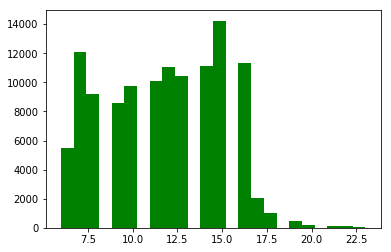

In [104]:
n, bins, patches = plt.hist(df['START_TIME'].dt.hour.values, 24, facecolor='green')

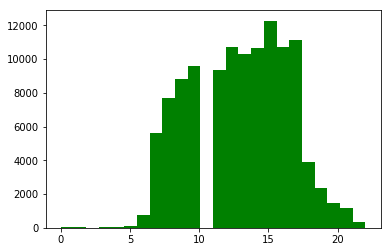

In [105]:
n, bins, patches = plt.hist(df['STOP_TIME'].dt.hour.values, 24, facecolor='green')

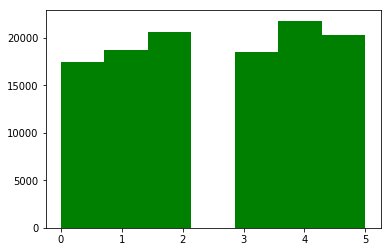

In [106]:
n, bins, patches = plt.hist(df['START_TIME'].dt.dayofweek.values, 7, facecolor='green')

## Data visualization

Let's plot the points we have on the map

In [468]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)
plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values)
)

plot.circle(x="lon", y="lat", size=1, fill_color='blue', fill_alpha=0.8, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Area split

We don't want to predict availability for each location but for bigger zone. Let's group locations into squared areas. 

We will mark each area by its index and each pair of Lat & Lon can be mapped to the index. 

`index = lon * amount_of_cols + lat`


In [107]:
class CoordinatesMapper(object):
    def __init__(self, minLon, minLat, maxLon, maxLat, hCount = 11, vCount = 11):
        ''' Maps lat lon to a cell.
            Keyword arguments:
            minLon -- min lon in data set
            minLat -- min lat in data set
            maxLon -- max lon in data set
            maxLat -- max lat in data set
            hCount -- amount of areas horisontally
            vCount -- amount of areas vertically
        '''
        self._ndig = 3
        self._minLon = minLon
        self._minLat = minLat
        self._maxLon = maxLon
        self._maxLat = maxLat
        self._hCount = hCount
        self._vCount = vCount
        self._cell_width_lon = round((self._maxLon - self._minLon) / self._hCount, self._ndig)
        self._cell_height_lat = round((self._maxLat - self._minLat) / self._vCount, self._ndig)
        
    def toIndex(self, lon, lat):
        y = int(round(lat - self._minLat, self._ndig) / self._cell_height_lat)
        x = int((lon - self._minLon) / self._cell_width_lon)
        
        return self._hCount * y + x

Add a new column that will hold the area index

In [108]:
mapper = CoordinatesMapper(df.Lon.min(), df.Lat.min(), df.Lon.max(), df.Lat.max(), hCount = h_area_split_by, vCount = v_area_split_by)
df['zone_index'] = df.apply(lambda row: mapper.toIndex(row['Lon'] ,row['Lat']), axis = 1)
print ('Area is split into {0} unique subareas'.format( df['zone_index'].nunique()))

Area is split into 31 unique subareas


## Areas visualization

Let's display the areas after the split.


In [283]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=1, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Downsample the time intervals

In [109]:
# The following approach is wrong.
#df['same_time_parkings'] = df.apply(lambda row:  df[(row.zone_index == df.zone_index) & (row.START_TIME < df.STOP_TIME) & (row.STOP_TIME > df.START_TIME)]['START_TIME'].count(), axis = 1)
#df.groupby('zone_index')['same_time_parkings'].max()

In [110]:
zones = df.zone_index.unique()
zones.sort()
zones

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [111]:
period_start = df.START_TIME.min().normalize()
period_end = df.STOP_TIME.max().normalize()

print('{0} - {1}'.format(period_start, period_end))

2017-04-01 00:00:00 - 2017-10-01 00:00:00


In [112]:
timestamps = pd.date_range(period_start, period_end, freq='{0}min'.format(downsampling_interval_in_minutes)).values
timestamps

array(['2017-04-01T00:00:00.000000000', '2017-04-01T01:00:00.000000000',
       '2017-04-01T02:00:00.000000000', ...,
       '2017-09-30T22:00:00.000000000', '2017-09-30T23:00:00.000000000',
       '2017-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [113]:
lists = [timestamps, zones]
zones_availability = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone_index'])

print('{0} - size of df before dropping rows'.format(len(zones_availability)))
ds_cleaner.cleanup(zones_availability, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df before dropping rows'.format(len(zones_availability)))

zones_availability = zones_availability.sort_values(by=['zone_index', 'timestamp'])
zones_availability['parked'] = 0
zones_availability.head()

136183 - size of df before dropping rows
82739 - size of df before dropping rows


timestamp  zone_index  parked
186 2017-04-01 06:00:00           0       0
217 2017-04-01 07:00:00           0       0
248 2017-04-01 08:00:00           0       0
279 2017-04-01 09:00:00           0       0
310 2017-04-01 10:00:00           0       0

In [114]:
#rows = [['2017-09-30 11:02:00','2017-09-30 11:15:00',1],
#['2017-09-30 11:33:00','2017-09-30 11:54:00',1],
#['2017-09-30 12:43:00','2017-09-30 13:50:00',1],
#['2017-09-30 12:50:00','2017-09-30 12:58:00',1],
#['2017-09-30 12:56:00','2017-09-30 14:24:00',1]]
#df = pd.DataFrame(rows, columns=['START_TIME','STOP_TIME', 'zone_index'])

#df.START_TIME = pd.to_datetime(df.START_TIME)
#df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
#df.dtypes

#timestamps = pd.DataFrame(pd.Series(pd.date_range('2017-09-29 00:00:00', '2017-09-30 00:00:00', freq="30min").values), columns=['timestamp'])
#zones = pd.DataFrame(pd.Series([1, 2]), columns=['zone'])
#lists = [timestamps['timestamp'].values, zones['zone'].values]
#res = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone'])
#res.sort_values(by=['zone'])

In [115]:
def downsample_time(start, end, zone_index, minutes):
    result = []
    
    for i in range(len(ranges)-1):
        st = pd.Timestamp(start.date()) + ranges[i]
        ed = pd.Timestamp(start.date()) + ranges[i + 1]
        
        #print ('st={0}, ed={1}, -- start={2}, end={3}'.format(st, ed, start, end))
        parked = 0
        if start < ed and end > st:
            parked = 1
        
        result.append((st, parked))
    
    return result

In [116]:
ranges = pd.timedelta_range('0 days 0 hours 0 minutes', periods=(24*60)/downsampling_interval_in_minutes, freq='{0}min'.format(downsampling_interval_in_minutes))

rows = []
for i, row in df.iterrows():
    time_ranges = downsample_time(row.START_TIME, row.STOP_TIME, row.zone_index, ranges)
    #list(my_dataframe.columns.values)
    #row.values.tolist()
    for tr in time_ranges:
        rows.append([tr[0], row.zone_index, tr[1]])

In [117]:
downsampled_time_df = pd.DataFrame(rows, columns=['timestamp','zone_index', 'parked'])

print('{0} - size of df before dropping rows'.format(len(downsampled_time_df)))
ds_cleaner.cleanup(downsampled_time_df, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df after dropping rows'.format(len(downsampled_time_df)))

2699349 - size of df before dropping rows
1995171 - size of df after dropping rows


In [118]:
downsampled_time_df = pd.concat([zones_availability, downsampled_time_df])
downsampled_time_df = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum()

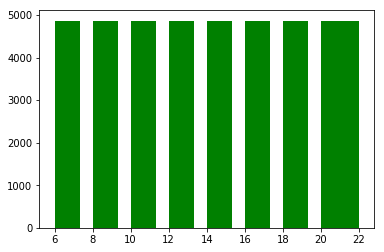

In [119]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.hour.values, 24, facecolor='green')

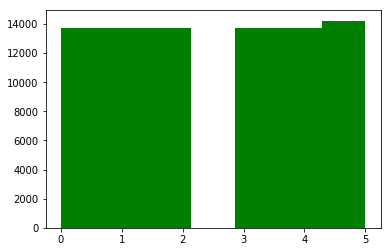

In [120]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.dayofweek.values, 7, facecolor='green')

In [121]:
downsampled_time_df.describe()

zone_index        parked
count  82739.000000  82739.000000
mean      15.000000      3.500369
std        8.944326      6.880951
min        0.000000      0.000000
25%        7.000000      0.000000
50%       15.000000      0.000000
75%       23.000000      4.000000
max       30.000000     70.000000

## Save DataFrame with downsampled timestamps

In [122]:
downsampled_time_df.to_csv(file_name_prefix + 'downsampled_time.csv', index=False)

## Read DataFrame with downsampled timestamps

In [123]:
downsampled_time_df = pd.read_csv(file_name_prefix + 'downsampled_time.csv')
downsampled_time_df.timestamp = pd.to_datetime(downsampled_time_df.timestamp)
downsampled_time_df.dtypes

timestamp     datetime64[ns]
zone_index             int64
parked                 int64
dtype: object

In [124]:
len(downsampled_time_df)

82739

In [125]:
len(downsampled_time_df[downsampled_time_df.parked == 0])

44411

## Area capacity

We estimate total amount of parking spots by historical max amount of simultaniously parked cars.

In [126]:
zone_capacity = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum().groupby('zone_index', as_index=False).max()
zone_capacity = zone_capacity.drop(columns=['timestamp'])
zone_capacity = zone_capacity.rename({'parked': 'spots_amount'}, axis='columns')
zone_capacity.describe()

zone_index  spots_amount
count   31.000000     31.000000
mean    15.000000     20.548387
std      9.092121     23.638723
min      0.000000      1.000000
25%      7.500000      1.000000
50%     15.000000     10.000000
75%     22.500000     32.500000
max     30.000000     70.000000

In [127]:
#zone_capacity.sort_values(by=['spots_amount','zone_index'], ascending=False)
zone_capacity

zone_index  spots_amount
0            0             1
1            1             1
2            2             2
3            3            10
4            4            28
5            5             1
6            6             1
7            7             8
8            8            52
9            9            66
10          10             4
11          11            18
12          12            66
13          13            66
14          14            70
15          15            32
16          16            33
17          17            30
18          18             2
19          19             1
20          20            53
21          21            36
22          22            15
23          23             1
24          24             3
25          25            18
26          26            14
27          27             2
28          28             1
29          29             1
30          30             1

In [128]:
downsampled_time_df.head()

timestamp  zone_index  parked
0 2017-04-01 06:00:00           0       0
1 2017-04-01 06:00:00           1       0
2 2017-04-01 06:00:00           2       0
3 2017-04-01 06:00:00           3       1
4 2017-04-01 06:00:00           4       2

In [129]:
parking_per_datetime=downsampled_time_df.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )
parking_per_datetime.head(20)

timestamp  zone_index  parked  spots_amount
0  2017-04-01 06:00:00           0       0             1
1  2017-04-01 06:00:00           1       0             1
2  2017-04-01 06:00:00           2       0             2
3  2017-04-01 06:00:00           3       1            10
4  2017-04-01 06:00:00           4       2            28
5  2017-04-01 06:00:00           5       0             1
6  2017-04-01 06:00:00           6       0             1
7  2017-04-01 06:00:00           7       1             8
8  2017-04-01 06:00:00           8       1            52
9  2017-04-01 06:00:00           9       2            66
10 2017-04-01 06:00:00          10       0             4
11 2017-04-01 06:00:00          11       3            18
12 2017-04-01 06:00:00          12       0            66
13 2017-04-01 06:00:00          13       5            66
14 2017-04-01 06:00:00          14       1            70
15 2017-04-01 06:00:00          15       1            32
16 2017-04-01 06:00:00          16       1            33
17 2017-04-01 06:00:00          17       1            30
18 2017-04-01 06:00:00          18       0             2
19 2017-04-01 06:00:00          19       0             1

In [130]:
if limit_by_spots > -1:
    parking_per_datetime = parking_per_datetime[parking_per_datetime.spots_amount >= limit_by_spots]

## Create Availability labels

For now it will be only two labels:
 - free
 - busy
 
Label is 1(busy) when ratio parked/capacity > 0.5, otherwise it is 0(free)

In [131]:
parking_per_datetime['availability'] = round((parking_per_datetime['parked'] / parking_per_datetime['spots_amount']))
parking_per_datetime.head()

timestamp  zone_index  parked  spots_amount  availability
3 2017-04-01 06:00:00           3       1            10           0.0
4 2017-04-01 06:00:00           4       2            28           0.0
7 2017-04-01 06:00:00           7       1             8           0.0
8 2017-04-01 06:00:00           8       1            52           0.0
9 2017-04-01 06:00:00           9       2            66           0.0

In [132]:
#sorteddf = parking_per_datetime.sort_values(by=['zone_index', 'timestamp'])
#sorteddf.to_csv(file_name_prefix + 'sorted.csv', index=False)

## TODO

In [133]:
parking_per_datetime.describe()

zone_index        parked  spots_amount  availability
count  45373.000000  45373.000000  45373.000000  45373.000000
mean      14.294118      6.372314     36.176471      0.049964
std        6.736845      8.250128     21.086150      0.217872
min        3.000000      0.000000      8.000000      0.000000
25%        9.000000      1.000000     18.000000      0.000000
50%       14.000000      3.000000     32.000000      0.000000
75%       20.000000      8.000000     53.000000      0.000000
max       26.000000     70.000000     70.000000      1.000000

In [134]:
zdf = parking_per_datetime
#len(zdf[zdf.spots_amount < 5])
(len(zdf[zdf.availability == 1]) / len(zdf))*100

4.9963634760760804

In [135]:
zone_info = parking_per_datetime.groupby(['zone_index', 'availability'], as_index=False).count()

zone_info = zone_info.drop(columns=['parked', 'spots_amount'])
zone_info = zone_info.rename({'timestamp': 'records_count'}, axis='columns')
zone_info['1_label_count'] = zone_info['availability'] * zone_info['records_count']
zone_info['0_label_count'] = (1 - zone_info['availability']) * zone_info['records_count']
zone_info = zone_info.groupby(['zone_index'], as_index=False).max()
zone_info = zone_info.drop(columns=['availability'])
zone_info['records_count'] = zone_info['0_label_count'] + zone_info['1_label_count']

zone_info['k'] = zone_info['1_label_count'] / zone_info['records_count']
zone_info=zone_info.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )

zone_info = zone_info.sort_values(by=['k','1_label_count'], ascending=False)

zone_info

zone_index  records_count  1_label_count  0_label_count         k  \
7           13         2669.0          528.0         2141.0  0.197827   
12          20         2669.0          447.0         2222.0  0.167478   
10          16         2669.0          260.0         2409.0  0.097415   
13          21         2669.0          260.0         2409.0  0.097415   
16          26         2669.0          169.0         2500.0  0.063320   
15          25         2669.0          120.0         2549.0  0.044961   
5           11         2669.0           96.0         2573.0  0.035969   
6           12         2669.0           88.0         2581.0  0.032971   
0            3         2669.0           73.0         2596.0  0.027351   
14          22         2669.0           67.0         2602.0  0.025103   
2            7         2669.0           57.0         2612.0  0.021356   
8           14         2669.0           36.0         2633.0  0.013488   
3            8         2669.0           25.0         2644.0  0.009367   
4            9         2669.0           16.0         2653.0  0.005995   
9           15         2669.0           15.0         2654.0  0.005620   
1            4         2669.0            7.0         2662.0  0.002623   
11          17         2669.0            3.0         2666.0  0.001124   

    spots_amount  
7             66  
12            53  
10            33  
13            36  
16            14  
15            18  
5             18  
6             66  
0             10  
14            15  
2              8  
8             70  
3             52  
4             66  
9             32  
1             28  
11            30

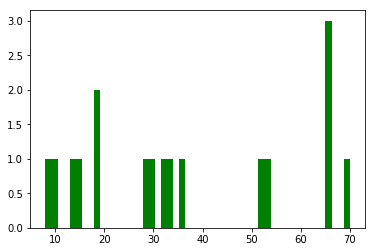

In [136]:
mu, sigma = 100, 15
x = zone_info.spots_amount.values

# the histogram of the data
n, bins, patches = plt.hist(x, 50, facecolor='green')

## Extract more features

In [137]:
weekdays = parking_per_datetime.timestamp.dt.weekday
parking_per_datetime = parking_per_datetime.assign(weekday = weekdays)
parking_per_datetime = parking_per_datetime.assign(hour = parking_per_datetime.timestamp.dt.hour)

In [138]:
dummies = pd.get_dummies(parking_per_datetime, columns=['zone_index','weekday', 'hour'])
dummies.columns

Index(['timestamp', 'parked', 'spots_amount', 'availability', 'zone_index_3',
       'zone_index_4', 'zone_index_7', 'zone_index_8', 'zone_index_9',
       'zone_index_11', 'zone_index_12', 'zone_index_13', 'zone_index_14',
       'zone_index_15', 'zone_index_16', 'zone_index_17', 'zone_index_20',
       'zone_index_21', 'zone_index_22', 'zone_index_25', 'zone_index_26',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22'],
      dtype='object')

In [139]:
dummies.sort_values(by=['timestamp'], inplace=True)
dummies.drop(columns=['timestamp', 'parked', 'spots_amount',], inplace=True)

## Train a model

In [140]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [142]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [143]:
validate_and_test = dummies.tail(validation_size + test_size)

In [144]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [145]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [146]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

lambdas = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l1', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.571858877381
0.593128127546


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.533317816828
0.532553628923


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5
0.5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5


In [147]:
m = models[max(models.keys())]

In [148]:
fdf = pd.DataFrame(X_train.columns)
fdf['k'] = pd.Series(m.coef_[0])
fdf.sort_values(by=['k'], inplace=True)
fdf

0          k
11  zone_index_17 -90.360068
23         hour_6 -89.509957
37        hour_20 -66.256791
1    zone_index_4 -60.711815
38        hour_21 -59.362492
39        hour_22 -56.756411
36        hour_19 -35.590213
17      weekday_0 -11.058387
22      weekday_5 -10.915329
9   zone_index_15  -7.509319
19      weekday_2  -4.500737
20      weekday_3  -3.431003
4    zone_index_9  -3.235857
3    zone_index_8  -2.969755
18      weekday_1  -1.657898
2    zone_index_7   0.000000
5   zone_index_11   0.000000
21      weekday_4   3.025521
0    zone_index_3   3.393540
8   zone_index_14   5.688808
10  zone_index_16   7.822079
6   zone_index_12   8.014050
35        hour_18   8.461000
34        hour_17   9.230866
14  zone_index_22   9.555256
16  zone_index_26  12.993678
13  zone_index_21  14.388274
12  zone_index_20  14.732860
29        hour_12  16.854889
24         hour_7  17.466522
15  zone_index_25  19.591965
25         hour_8  20.675353
30        hour_13  22.387107
33        hour_16  22.797550
7   zone_index_13  23.556514
28        hour_11  25.182338
26         hour_9  25.537262
32        hour_15  26.943850
27        hour_10  29.019722
31        hour_14  34.632079

In [149]:
from sklearn.ensemble import RandomForestClassifier

ns = [2, 5, 10, 20, 100]

ds = [10, 20, 30, 40, 50, 60, 70]

#n = 100
#d = 2

for n in ns:
    for d in ds:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=100)
        clf.fit(X_train.values, y_train.values)
        y_pred = clf.predict(X_validate.values)
        fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
        auc = metrics.auc(fpr, tpr)
        print('n:{0} d:{1} = auc:{2}'.format(n,d, auc))

n:2 d:10 = auc:0.526987082509019
n:2 d:20 = auc:0.5690562085418364
n:2 d:30 = auc:0.5707882384886923
n:2 d:40 = auc:0.5707882384886923
n:2 d:50 = auc:0.5707882384886923
n:2 d:60 = auc:0.5707882384886923
n:2 d:70 = auc:0.5707882384886923
n:5 d:10 = auc:0.5175627448698553
n:5 d:20 = auc:0.5640792893440397
n:5 d:30 = auc:0.5710908103495093
n:5 d:40 = auc:0.5710908103495093
n:5 d:50 = auc:0.5710908103495093
n:5 d:60 = auc:0.5710908103495093
n:5 d:70 = auc:0.5710908103495093
n:10 d:10 = auc:0.5088191939175297
n:10 d:20 = auc:0.5625741882927965
n:10 d:30 = auc:0.5661138911517126
n:10 d:40 = auc:0.5661138911517126
n:10 d:50 = auc:0.5661138911517126
n:10 d:60 = auc:0.5661138911517126
n:10 d:70 = auc:0.5661138911517126
n:20 d:10 = auc:0.5094243376391636
n:20 d:20 = auc:0.5558652391481438
n:20 d:30 = auc:0.5614395438147329
n:20 d:40 = auc:0.5614395438147329
n:20 d:50 = auc:0.5614395438147329
n:20 d:60 = auc:0.5614395438147329
n:20 d:70 = auc:0.5614395438147329
n:100 d:10 = auc:0.5094243376391636

Random Forest doesn't outperform the previous model (which was Gradient Descent classifier). That is why we will choose the SGD classifier. We will try to add some new features.

First let's add feature interaction and see what will happen.

In [150]:
class FeatureProcessor(object):
    def add_interaction(self, df, columns):
        # collect the columns
        cols = {}

        for c in columns:
            cols[c] = []

        for dfc in df.columns:
            for c in columns:
                if dfc.startswith(c):
                    cols[c].append(dfc)

        keys = []

        for k in cols.keys():
            keys.append(k)

        new_keys = []
        self._combine(keys, 0, new_keys, cols, len(columns), [])

        for n_key in new_keys:
            n_key_name = self._to_name(n_key)
            df[n_key_name] = df.apply(lambda row: self._get_row_val(row, n_key) , axis = 1)

    def _get_row_val(self, row, n_key):
        all_ones = 1
        for nk in n_key:
            if row[nk]!=1:
                all_ones = 0
                break
        return all_ones

    def _to_name(self, key):
        return '_'.join(key)

    def _combine(self, keys, idx, res, cols, n, cur_key):

        if len(cur_key) == n:
            res.append(cur_key)

        if idx >= n:
            return

        for i in range(idx, len(keys)):
            k = keys[i]
            vals = cols[k]
            for j in range(len(vals)):
                self._combine(keys, i+1, res,cols, n, cur_key + [vals[j]])

In [151]:
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_25', 'zone_index_26', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22'], dtype=object)

In [152]:
#size = len(dummies)
#sample = dummies.head(100)

In [153]:
fp = FeatureProcessor()
fp.add_interaction(dummies, columns=['weekday', 'hour'])
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_25', 'zone_index_26', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'weekday_0_hour_6',
       'weekday_0_hour_7', 'weekday_0_hour_8', 'weekday_0_hour_9',
       'weekday_0_hour_10', 'weekday_0_hour_11', 'weekday_0_hour_12',
       'weekday_0_hour_13', 'weekday_0_hour_14', 'weekday_0_hour_15',
       'weekday_0_hour_16', 'weekday_0_hour_17', 'weekday_0_hour_18',
       'weekday_0_hour_19', 'weekday_0_hour_20', 'weekday_0_hour_21',
       'w

In [154]:
len(dummies.columns.get_values())

143

In [155]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [157]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [158]:
validate_and_test = dummies.tail(validation_size + test_size)

In [159]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [160]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [161]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

#lambdas = [0.00000001,0.0000001,0.00000013,0.00000015,0.00000017,0.00000019]

lambdas = [0.0000000001,0.000000005,0.00000001,0.0000001,0.000001,0.00001,0.0001]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l2', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.56140657124


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.54942588929


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.584444703053


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.53759067458


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.531721556306
